In [1]:
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(tidyverse)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### functions

In [2]:
read_genetable_collapsed <- function(file_path){
    #import collapsed genetable
    genetable_collapsed <- na.omit(read.table(
        file_path, header = FALSE, #skip = 4, 
        sep = '\t', na.strings = ' '))

    genetable_collapsed[4,3:length(genetable_collapsed)] = apply(
        genetable_collapsed[1:4,3:length(genetable_collapsed)], 2, paste, collapse="_")

    colnames(genetable_collapsed) <- genetable_collapsed[4,]
    genetable_collapsed = genetable_collapsed[5:dim(genetable_collapsed)[1],] %>% data.frame
}

In [3]:
get_score_df <- function(genetable_collapsed,score,up_hit='resistance_hit',down_hit='sensitivity_hit',threshold = 4){
    df = genetable_collapsed[,c('gene', 
                                paste0(score,'_ave_Rep1_Rep2_Mann.Whitney.p.value_'),
                                paste0(score,'_ave_Rep1_Rep2_average.phenotype.of.strongest.3_'))
          # which (unlist(gregexpr('rho_ave_Rep1_Rep2', colnames(genetable_collapsed))) == 1))
    ] %>% remove_rownames
    rownames(df) = seq(length=nrow(df))

    colnames(df) <- c('gene','pvalue','score')

    df$score = df$score %>% as.double
    df$pvalue = df$pvalue %>% as.double

    #create dataframe with pseudogene phenotypes
    df$label = '.'

    df %>% mutate(label = replace(label, grepl('pseudo', df[[1]], fixed = TRUE), 'pseudo')) -> df

    pseudo_sd <- df %>% filter(label=='pseudo') %>% select(score) %>% as.list %>% unlist %>% sd

    df %>%
        mutate(label = replace(
            label,score > 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) >= threshold,
            up_hit
        ))-> df
    df %>%
        mutate(label = replace(
            label,score < 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) <= -threshold,
            down_hit
        )) -> df
    df %>% mutate(label = replace(label, label == '.', 'gene_non_hit')) -> df

    # reorder factors
    df$label <- factor(df$label, levels = c(down_hit, up_hit,'gene_non_hit','pseudo'))
    
    out = list()
    out[["data"]] = df
    out[["pseudo_sd"]] = pseudo_sd
    return(out)
}

In [4]:
# scale_color_manual(values = c('#3182bd', '#de2d26'),
#                    labels = c('Sensitizing Hits', 'Resistance Hits'))

plot_volcano <- function(df, pseudo_sd, score = 'rho',threshold = 4,
                         up_hit='resistance_hit',down_hit='sensitivity_hit'){
    
    draw_threshold <- function(x){threshold * pseudo_sd * sign(x)/(x)}

    p <- df %>% drop_na %>%
        ggplot(aes(x=score,y=-1*log10(pvalue)) ) + 
        geom_point(
            data = df %>% filter(label=='pseudo'), 
            size = 1, color = 'gray80') +
        geom_point(
            data = df %>% filter(label=='gene_non_hit'), 
            size = 1, color = 'gray90') +
        geom_point(
            data = df %>% filter(label==up_hit), 
            size = 2, color = '#fcae91') + 
        geom_point(
            data = df %>% filter(label==down_hit), 
            size = 2, color = '#bdd7e7') 
    
    if (score == 'gamma'){
        p + xlab(expression('CRISPRi control phenotype (' * gamma * ')')) -> p
    } 
    if (score == 'rho'){
        p + xlab(expression('CRISPRi drug phenotype (' * rho * ')')) -> p
    }
    p +
        theme_classic() +
        xlim(-1.0, 1.0) +
        scale_y_continuous(limits = c(0.5,4.5)) +
        ylab(expression('-log'[10] * '(Mann-Whitney p-value)')) +
        stat_function(fun = draw_threshold, linetype = 'dashed', color = 'black') -> p
    
    return(p)
}

label_sensitivity_hit <- function(p,dd, size = 3, t_x = -0.2, t_y = -0.1){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        stroke=0.5, 
        colour = "grey30", fill = "#3182bd"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

label_resistance_hit <- function(p,dd, size = 3, t_x = 0.2, t_y = 0.1){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        stroke=0.5, 
        colour = "grey30", fill = "#de2d26"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

In [5]:
draw_labeled_volcano <- function(p1, size = 3){
    ### Genes to label:
    # # 1. Decapping proteins: DCP2, DCP1A, DCPS
    # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('DCP2','DCP1A', 'DCPS')))
    # # 2. BCL2 family proteins: BCL2, MCL1
    # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('BCL2')), t_y=+0.1)
    # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('MCL1')), t_x = -0.2, t_y = -0.3)
    # # 3. Positive controls: DCK, SLC29A1
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('DCK','SLC29A1')),t_y=-0.2)
    # # 4. m6A writers: METTL3, CBLL1, ZC3H13, KIAA1429
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('METTL3')))
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('KIAA1429')))
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('CBLL1')),t_y=+0.2)
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('ZC3H13')),t_y=-0.1)
    # p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('YTHDF2')),t_y=-0.1, size = size)

    # Splicing 
    p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c(
        'SNRPD2','SNRPB2','SNRPA1','SNRPG','SF3A3'
    )),t_y=-0.1, size = size)
    
    p1 <- label_resistance_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('SF3B5')),t_y=-0.1, size = size)
    
    
#     # 5. target genes: SQLE, INTS5, MYBBP1A
#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('SQLE')))
#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('INTS5')), t_y=+0.1)
#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('MYBBP1A')), t_y=+0)

#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('MYB')), t_y=+0)
#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('PTEN')), t_y=+0)

#     # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('METTL9')), size = size)
#     p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('YTHDC1')),t_y=+0.1, size = size)
#     # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('SETDB1')), size = size)
#     # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('ATF7IP')),t_y=+0.1, size = size)

#     # p1 <- label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% c('TET')),t_y=+0.1, size = size)
    
    return(p1)
}

In [6]:
draw_geneset_volcano <- function(df, geneset, title, size = 3){
    df$label = 'gene_non_hit'
    
    plot_volcano(df,0,score='rho') + 

        geom_point(
            data = df %>% filter(gene %in% geneset), 
            size = size, stroke = 0.5, 
            colour = "grey30", fill = "black"
        # ) + 
        # geom_rug(
        #     data = df %>% filter(gene %in% geneset), 
        #     size = .1, stroke = 0, 
        #     colour = "black"
        ) + 
        ggtitle(title) + theme(
        plot.title = element_text(size = 20,hjust = 0.5),
        axis.text.y = element_text(size = 15, color = 'black'),
        axis.title.y = element_text(size = 16),
        axis.text.x = element_text(size = 15, color = 'black'),
        axis.title.x = element_text(size = 16),
        legend.title = element_blank(),
        legend.text = element_text(size = rel(1.5), color = 'black'),
        legend.position = 'right'
        ) -> p
    return (p)
}

# hl60_exp1 DAC

In [8]:
hl60_exp1_DAC_genetable_collapsed = read_genetable_collapsed('hl60_exp1/genetable_collapsed.txt')

### rho – $\rho$

In [9]:
hl60_exp1_DAC_rho = get_score_df(hl60_exp1_DAC_genetable_collapsed,"rho", threshold = 1)

In [10]:
hl60_exp1_DAC_rho$data %>% group_by(label) %>% count

label,n
<fct>,<int>
sensitivity_hit,2310
resistance_hit,1984
gene_non_hit,14611
pseudo,18905


In [11]:
hl60_exp1_DAC_rho$data %>% filter((label != 'gene_non_hit') & grepl('SF3', gene, fixed = TRUE))

gene,pvalue,score,label
<chr>,<dbl>,<dbl>,<fct>
ACSF3,0.016055658,0.11445467,resistance_hit
CPSF3,0.042236451,0.07857830,resistance_hit
CSF3,0.153637159,0.15587941,resistance_hit
SF3A3,0.006557798,-0.13504091,sensitivity_hit
SF3B5,0.032559232,0.22927224,resistance_hit
TM7SF3,0.031811881,-0.14208547,sensitivity_hit
TM9SF3,0.095781082,-0.08940177,sensitivity_hit


In [12]:
hl60_exp1_DAC_rho$data %>% write.table(
    '../../../decitabine_rho.txt',sep='\t',quote=F,row.names=F
)

In [13]:
hl60_exp1_DAC_rho$p = plot_volcano(hl60_exp1_DAC_rho$data,hl60_exp1_DAC_rho$pseudo_sd,score='rho', threshold= 1)

In [14]:
# draw_geneset_volcano(
#     hl60_exp1_DAC_rho$data, c(
#         'INTS8','NIPBL','INTS12','INTS1','INTS9','INTS7','INTS5','INTS4',
#         'CT45A1','INTS6','SAGE1'
#     ),
#     'GOCC_INTEGRATOR_COMPLEX'
# )

Warning message:
“Removed 23753 rows containing missing values (geom_point).”
Warning message:
“Removed 101 row(s) containing missing values (geom_path).”


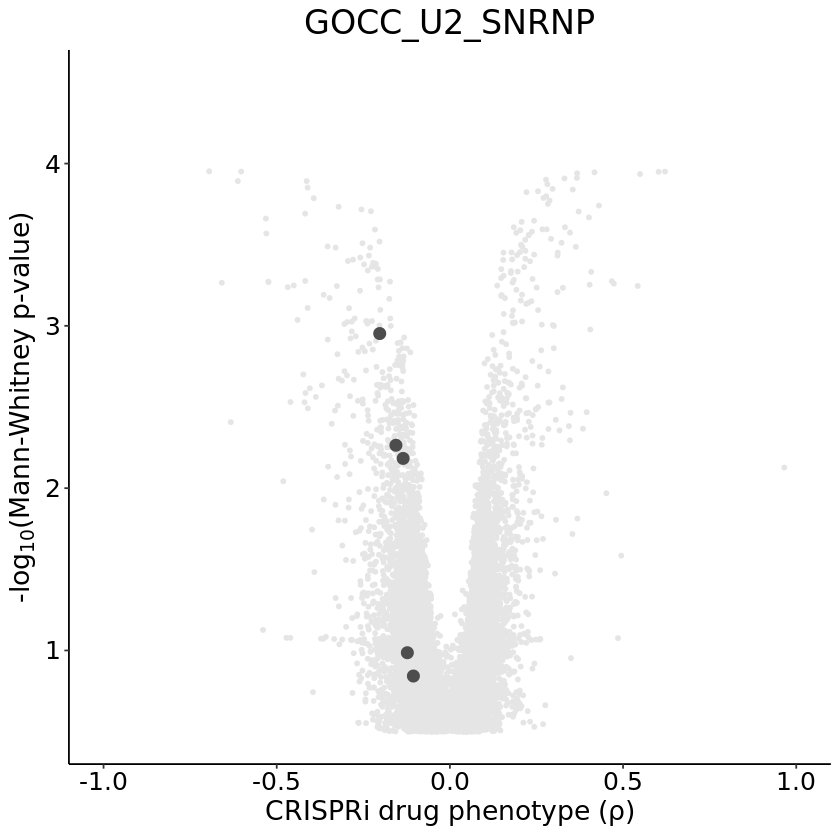

In [15]:
draw_geneset_volcano(
    hl60_exp1_DAC_rho$data, c(
        'SNRPD2','SNRPB2','SNRPA1','SNRPG','SF3A3'
    # 'SETX',
    # 'LUC7L',
    #  'PUF60',
     # 'SF1',
     # 'CELF1',
     # 'SF3A1',
     # 'PTBP2',
     # 'CELF6',
     # 'CELF4',
     # 'SRSF12','SRSF10','SRSF9','SRSF6','SNRPC',
     # 'PSIP1',
     # 'CELF2',
     # 'PRPF39',
     # 'CELF3',
     # 'CELF5',
     # 'LUC7L3'
    ),
    # 'GOBP_MRNA_SPLICE_SITE_SELECTION'
    'GOCC_U2_SNRNP'
)

In [16]:
paste0(
    hl60_exp1_DAC_rho$data %>% filter(label %in% c('sensitivity_hit','resistance_hit')) %>% nrow,
    " genes modulate cellular response to decitabine "
)

[1] "4294 genes modulate cellular response to decitabine "

### gamma – $\gamma$

In [17]:
gamma = get_score_df(genetable_collapsed = hl60_exp1_DAC_genetable_collapsed, 'gamma',up_hit = 'up',down_hit = 'down')

In [18]:
gamma$data %>% group_by(label) %>% count

label,n
<fct>,<int>
down,1723
up,158
gene_non_hit,17024
pseudo,18905


In [19]:
# gamma$data %>% filter(label == 'up')

In [20]:
# gamma$vol = plot_volcano(gamma$data,gamma$pseudo_sd,score='gamma',up_hit = 'up',down_hit = 'down')

# gamma$vol + theme(axis.text.x = element_text(size = 15, color = 'black'),
#           axis.text.y = element_text(size = 15, color = 'black'),
#           axis.title.x = element_text(size = 16),
#           axis.title.y = element_text(size = 16),
#           legend.title = element_blank(),
#           legend.text = element_text(size = rel(1.5), color = 'black'),
#           legend.position = 'right'
# ) -> gamma$vol
# gamma$vol

In [21]:
paste0(gamma$data %>% filter(label == 'down') %>% nrow," essential genes")

[1] "1723 essential genes"

### gamma vs rho

In [22]:
df = data.frame(x=hl60_exp1_DAC_rho$data$score, y=gamma$data$score, 
           gene=hl60_exp1_DAC_rho$data$gene,
           rho=hl60_exp1_DAC_rho$data$label, gamma=gamma$data$label
          ) %>% drop_na

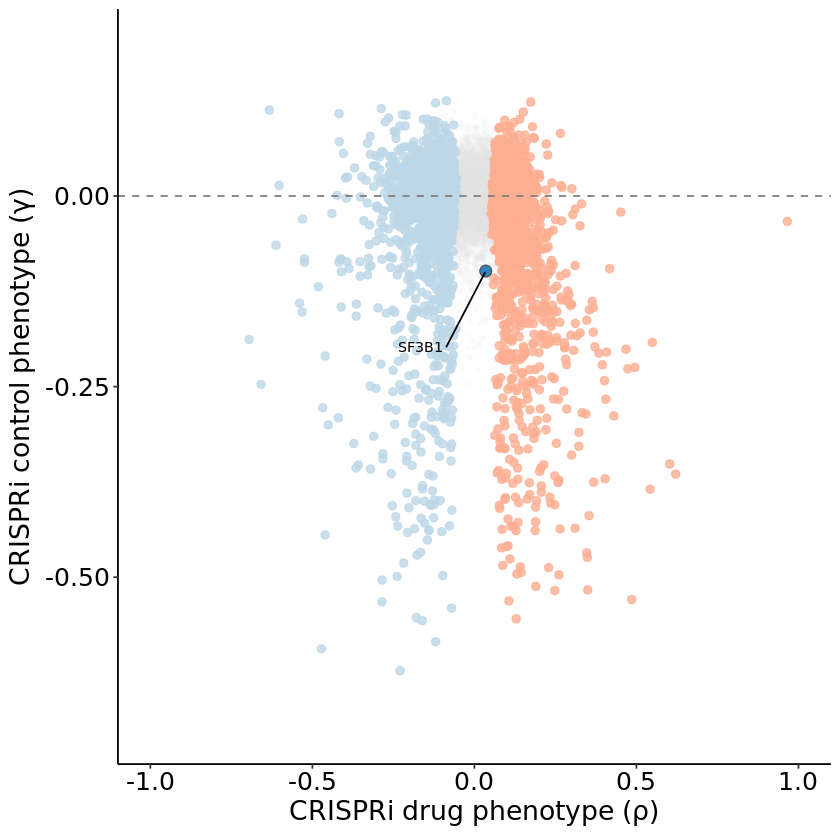

In [23]:
df %>% ggplot(aes(x=x, y=y)) + 
    geom_point(
        data = df %>% filter(gamma=='gene_non_hit' & rho=='gene_non_hit'), 
        alpha=10/100, size = 1, color = 'gray90') +
    # geom_point(
    #     data = df %>% filter(gamma=='pseudo'), 
    #     alpha=1/100, size = 1, color = 'yellow') +
    geom_point(
        data = df %>% filter(rho=='resistance_hit'), 
        alpha=80/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = df %>% filter(rho=='sensitivity_hit'), 
        alpha=80/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
    xlim(-1.0, 1.0) +
    ylim(-0.7, 0.2) +
    ylab(expression('CRISPRi control phenotype (' * gamma * ')')) +
    xlab(expression('CRISPRi drug phenotype (' * rho * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> pp

pp <- label_sensitivity_hit(pp, df %>% filter(gene %in% c(
#     # 'BCL2','SQLE', 'INTS5', 'MYBBP1A',"SETDB1",
#     "DNMT1",
    # "YTHDC1"
    "SF3B1"
)))
pp <- label_resistance_hit(pp, df %>% filter(gene %in% c(
    # 'DCK',
    # 'METTL3',"YTHDF2"
    # 'INTS8','NIPBL',
    # 'INTS12',
    # 'INTS1','INTS9','INTS7',
    # 'INTS5','INTS4',
    #'CT45A1','INTS6','SAGE1'
    # 'CEBPZ'
)))
# pp <- label_resistance_hit(pp, df %>% filter(gene %in% c(
#     "MAT2A"    
# )),size = 5,t_x = -0.1, t_y = -0.1)

pp + geom_hline(yintercept = 0,linetype = 'dashed', color = 'gray50') -> pp
pp


In [24]:
# ggsave('plots/CRISPRi-rho_vs_gamma_v1.pdf',pp, width = 6, height = 6)

# hl60_exp2

In [47]:
hl60_exp2_DAC_genetable_collapsed = read_genetable_collapsed('hl60_exp2/DAC_processing_output_genetable_collapsed.txt')

In [36]:
hl60_exp2_GSK_genetable_collapsed = read_genetable_collapsed('hl60_exp2/GSK_processing_output_genetable_collapsed.txt')

### rho – $\rho$

In [37]:
hl60_exp2_DAC_rho = get_score_df(hl60_exp2_DAC_genetable_collapsed,"rho")
hl60_exp2_GSK_rho = get_score_df(hl60_exp2_GSK_genetable_collapsed,"rho")

In [38]:
hl60_exp2_DAC_rho$data %>% group_by(label) %>% count
hl60_exp2_GSK_rho$data %>% group_by(label) %>% count

label,n
<fct>,<int>
sensitivity_hit,268
resistance_hit,271
gene_non_hit,18366
pseudo,18905


label,n
<fct>,<int>
sensitivity_hit,300
resistance_hit,368
gene_non_hit,18237
pseudo,18905


In [39]:
hl60_exp2_DAC_rho$p = plot_volcano(hl60_exp2_DAC_rho$data,hl60_exp2_DAC_rho$pseudo_sd,score='rho')
hl60_exp2_GSK_rho$p = plot_volcano(hl60_exp2_GSK_rho$data,hl60_exp2_GSK_rho$pseudo_sd,score='rho')

# rho volcano plots

### gene level

In [48]:
p1 = draw_labeled_volcano(hl60_exp1_DAC_rho$p, size = 3)

p1 <- p1 + ggtitle("hl60_exp1_DAC_rho") + theme(
    # plot.title = element_text(hjust = 0.5),
    axis.text.y = element_text(size = 15, color = 'black'),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 15, color = 'black'),
    axis.title.x = element_text(size = 16),
    legend.title = element_blank(),
    legend.text = element_text(size = rel(1.5), color = 'black'),
    legend.position = 'right'
    )

Warning message:
“Removed 12365 rows containing missing values (geom_point).”
Warning message:
“Removed 11357 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 25 rows containing missing values (geom_point).”
Warning message:
“Removed 88 row(s) containing missing values (geom_path).”


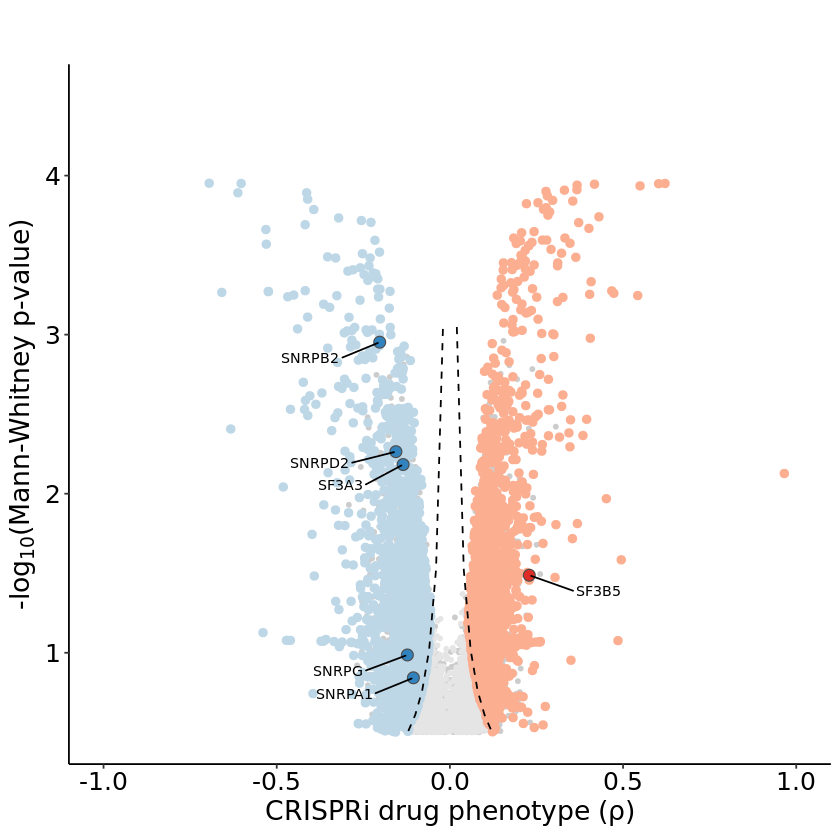

In [41]:
p1 + 
    ggtitle("") + #RNA N6-methyladenosine (m6A)\nand histone methylation
    theme(plot.title = element_text(hjust = 0.5,size = 30))

In [42]:
# ggsave('plots/CRISPRi-rho_volcano_v4.eps',width = 6, height = 6,device='eps')

### gene set

In [43]:
# GOBP_RNA_MODIFICATION = c('ADAT2','CDKAL1','CMTR1','CMTR2','DTWD1','FTSJ1','NOP2','NSUN2','RPUSD1','THUMPD2',
#   # 'ALKBH3','ALKBH5','DUS3L','LCMT2','METTL16','NAT10','NHP2',
#   # 'C9orf64','MEPCE','METTL1','METTL14','METTL5','NSUN4','NSUN6','PARN','RBM15','RPUSD3','RPUSD4','TRMT10A','TRUB1','TRUB2','URM1',
#   'AARS2','ALKBH1','ALKBH8','ANKRD16','BCDIN3D','CBLL1','CTU1','CTU2','DKC1','DUS2','ELP2','ELP3','ELP4','ELP5','ELP6','FTO','FTSJ3','GAR1','GTPBP3','KTI12','METTL3','METTL4','NAF1','PUS7L','PUSL1','RPUSD2','SSB','TPRKB','TRMT10C','TRMT2B','WDR4','ZC3H13'
# )


Warning message:
“Removed 23753 rows containing missing values (geom_point).”
Warning message:
“Removed 101 row(s) containing missing values (geom_path).”


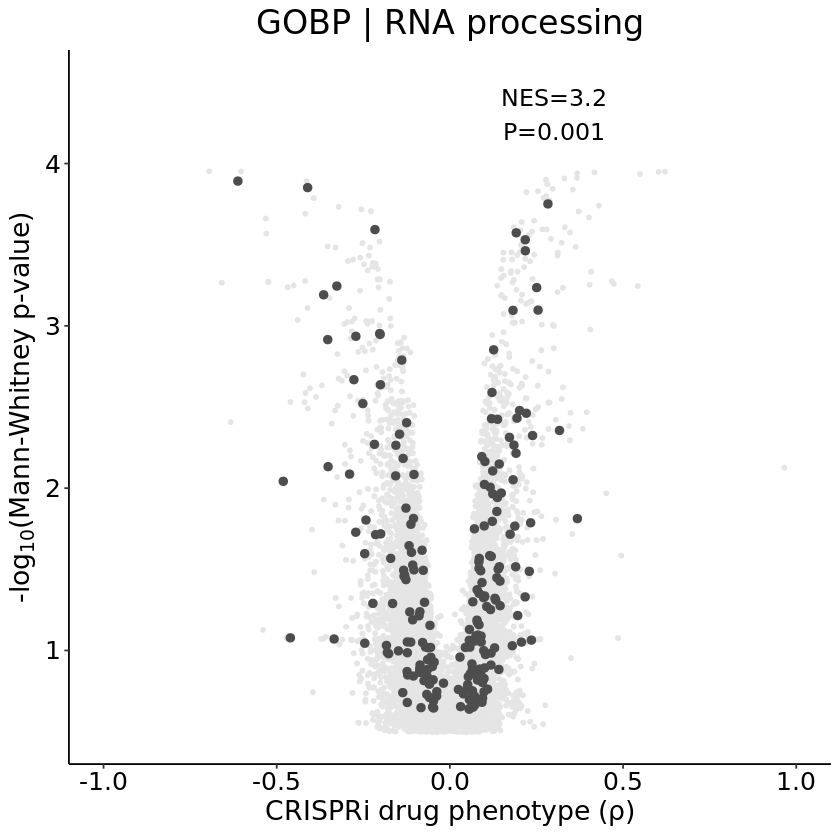

In [44]:
draw_geneset_volcano(
    hl60_exp1_DAC_rho$data,
    read.table('GOBP_MRNA_PROCESSING_gsea_leading_edge.csv')$V1,
    'GOBP | RNA processing',size=2
) + annotate("text", x=0.3, y=4.3, label= "NES=3.2\nP=0.001",size=5)
#%>% draw_labeled_volcano(size = 2)

In [45]:
ggsave('plots/CRISPRi-rho_volcano_GOBP_MRNA_PROCESSING.eps',width = 4.5, height = 4.5,device='eps')

Warning message:
“Removed 23753 rows containing missing values (geom_point).”
Warning message:
“Removed 101 row(s) containing missing values (geom_path).”


___

In [32]:
p1 <- draw_labeled_volcano(hl60_exp1_DAC_rho$p)

p1 <- p1 + ggtitle("hl60_exp1_DAC_rho") + theme(
    # plot.title = element_text(hjust = 0.5),
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.text.y = element_text(size = 15, color = 'black'),
    axis.title.y = element_blank(),
    legend.title = element_blank(),
    legend.text = element_text(size = rel(1.5), color = 'black'),
    legend.position = 'right'
    )

In [33]:
p2 = draw_labeled_volcano(hl60_exp2_DAC_rho$p)
p3 = draw_labeled_volcano(hl60_exp2_GSK_rho$p)

p2 <- p2 + ggtitle("hl60_exp2_DAC_rho") + theme(
    # plot.title = element_text(hjust = 0.5),
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.text.y = element_text(size = 15, color = 'black'),
    axis.title.y = element_text(size = 16),
    legend.title = element_blank(),
    legend.text = element_text(size = rel(1.5), color = 'black'),
    legend.position = 'right'
    )

p3 <- p3 + ggtitle("hl60_exp2_GSK_rho") + theme(
    # plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 15, color = 'black'),
    axis.title.x = element_text(size = 16),
    axis.text.y = element_text(size = 15, color = 'black'),
    axis.title.y = element_blank(),
    legend.title = element_blank(),
    legend.text = element_text(size = rel(1.5), color = 'black'),
    legend.position = 'right'
    )

ERROR: Error in label_sensitivity_hit(p1, hl60_exp1_DAC_rho$data %>% filter(gene %in% : object 'hl60_exp2_DAC_rho' not found


In [34]:
p1/p2/p3

ERROR: Error in eval(expr, envir, enclos): object 'p2' not found


In [180]:
ggsave('plots/CRISPRi-rho_volcano-exp1-exp2.pdf',p1/p2/p3, width = 5, height = 9)

Warning message:
“Removed 13796 rows containing missing values (geom_point).”
Warning message:
“Removed 12778 rows containing missing values (geom_point).”
Warning message:
“Removed 54 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 12472 rows containing missing values (geom_point).”
Warning message:
“Removed 11683 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 22 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning 

# 

In [90]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1    forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7       
 [5] purrr_0.3.4        readr_2.0.2        tidyr_1.1.4        tibble_3.1.6      
 [9] tidyverse_1.3.1    RColorBrewer_1.1-2 ggrepel_0.9.1      ggplot2_3.3.5     

loaded via a namespace (and not attached):
 [1

In [68]:
# no_negs_res <- no_negs[c('DCK', 'SLC29A1', 'METTL3', 'YTHDF2', 'KIAA1429', 'CBLL1', 'ZC3H13'),]
# no_negs_res$cat2 <- ifelse(no_negs_res[[1]] %in% c('DCK', 'SLC29A1'), 'drug', 'm6a')
# no_negs_res <- no_negs[no_negs$V1 %in% c('DCK', 'SLC29A1'),]
# no_negs_sens <- no_negs[c('BCL2', 'MCL1', 'DCP2', 'DCPS', 'EDC3', 'DCP1A', 'CMTR2', 'LSM14A', 'CSDE1', 'PUM1', 'ZC3H18'),]
# no_negs_sens$cat2 <- ifelse(no_negs_sens[[1]] %in% c('BCL2', 'MCL1'), 'bcl2', 'decap')
# no_negs_sens <- no_negs[no_negs$V1 %in% c('BCL2', 'DCP2', 'DCPS', 'EDC3', 'DCP1A'),]
# no_negs_labels <- rbind(no_negs_res, no_negs_sens)
# head(no_negs_labels, n = 15)

# # reorder factors
# no_negs_labels$cat <- factor(no_negs_labels$cat, levels = c('sensitizing_hit', 'resistance_hit'))

# scale_shape_manual(values = c(16, 16, 16, 16), 
#                    labels = c('BCL-2 family', 'mRNA decapping', 'Drug metabolism', 'RNA methylation')) +
# scale_shape_manual(values = c(16, 16), 
#                    labels = c('Sensitizing Hits', 'Resistance Hits')) +
# geom_text_repel(data = no_negs[c('METTL3'),], 
# geom_text_repel(data = no_negs[c('DCK'),], 
# geom_text_repel(data = no_negs[c('SLC29A1'),], 
# geom_text_repel(data = no_negs[c('BCL2'),],
# geom_text_repel(data = no_negs[c('MCL1'),],
# geom_text_repel(data = no_negs[c('DCP2'),],
# geom_text_repel(data = no_negs[c('DCPS'),],
# geom_text_repel(data = no_negs[c('DCP1A'),],
# geom_text_repel(data = no_negs[c('EDC3'),],

# no_negs_res$cat2 <- ifelse(no_negs_res[[1]] %in% c('DCK', 'SLC29A1'), 'drug', 'm6a')
# no_negs_sens <- no_negs[c('TAF6L', 'SUPT20H', 'CCDC101', 'USP22'),]
# no_negs_sens$cat2 <- ('saga')
# no_negs_labels <- rbind(no_negs_res, no_negs_sens)

# head(no_negs_labels, n = 15)

# p <- ggplot(no_negs, aes(x = V29, y = -1 * log(V28, 10), label = V1)) +
# geom_point(data = no_negs, size = 1, color = 'gray90') +
# geom_point(data = resistance_hits, size = 1, color = '#fcae91') + 
# geom_point(data = sensitivity_hits, size = 1, color = '#bdd7e7') +
# theme_classic()+
# xlim(-1.0, 1.0) +
# scale_y_continuous(limits = c(0.5,4.7)) +
# xlab(expression('CRISPRi DNMTi phenotype (' * rho * ')')) +
# ylab(expression('-log'[10] * '(Mann-Whitney p-value)')) +
# theme(axis.text.x = element_text(size = 15, color = 'black'),
#       axis.text.y = element_text(size = 15, color = 'black'),
#       axis.title.x = element_text(size = 20),
#       axis.title.y = element_text(size = 20),
#       legend.title = element_blank(),
#       legend.text = element_text(size = rel(1.5), color = 'black'),
#       legend.position = 'none'
#       ) +

# stat_function(fun = draw_threshold_neg, linetype = 'dashed', color = 'black') +
# stat_function(fun = draw_threshold_pos, linetype = 'dashed', color = 'black')+
# geom_point(data = no_negs_labels, shape = 16, color = '#3182bd', size = 4) +
# geom_text_repel(data = no_negs[c('SUPT20H'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.3, nudge_y = 0.05) +
# geom_text_repel(data = no_negs[c('TAF6L'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.2) +
# geom_text_repel(data = no_negs[c('USP22'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.25, nudge_y = -0.27) +
# geom_text_repel(data = no_negs[c('CCDC101'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.4, nudge_y = -0.1)

# p

# ggsave(file = 'ray_volcano_plot_v2.eps', height = 5.5, width = 5.5)